In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import csv
import time
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn import datasets, neighbors, linear_model, preprocessing
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import precision_recall_fscore_support
from sklearn.cluster import MiniBatchKMeans, KMeans

from collections import Counter
from imblearn import under_sampling, over_sampling
from imblearn.under_sampling import RandomUnderSampler

In [2]:
data = pd.read_csv("train.csv")
data.head()


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
data["target"].mean()

0.036447517859182946

# Classification

- Data normalization
- data split into train and cv set

Code for gini (evaluation per the problem description). 
- For the best accuracy, we want a normalized gini score to be as close as possible to 1. 
- The gini score for a random classifier is 0. 
- Also, if we get a negative gini score, we can just reverse the outcome to get a positive gini score of the same magnitude. 
- Gini score is a good metric for a skewed dataset such as this one. 
- For the evaluation, it needs the 'probability' from the classifier, not just the prediction (0 or 1)! 

In [4]:
#helper functions
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

#results is a list of dictionaries
def evaluate_clf(estimator, X_train, y_train, X_cv, y_cv, filename):
    estimator_name = str(estimator).split("(")[0]
    fit = estimator.fit(X_train, y_train)
    accuracy = fit.score(X_cv, y_cv)
    gini_cv = gini_normalized(y_cv, estimator.predict_proba(X_cv)[:,1])
    gini_train = gini_normalized(y_train, estimator.predict_proba(X_train)[:,1])
    precision, recall, fscore, support = precision_recall_fscore_support(pd.Series(y_cv).values, estimator.predict(X_cv), pos_label=1, average='binary')
    #print(precision)
    filename = filename + '.pkl'
    joblib.dump(estimator, filename)
    results_list = [estimator_name, filename, accuracy, gini_cv, gini_train, precision, recall, fscore]
    return results_list

Let's normalize the data using scikitlearn preprocessing. Each column will have a mean of 0 and variance of 1. 
The output of normalizing is a numpy array, so we convert it back into a pandas dataframe. Note that we will not be normalizing 'y' values. 


In [6]:
scaler = StandardScaler()
X_np = scaler.fit_transform(data.drop(["target", "id"], axis=1))
print(X_np.shape)
normalized_data = pd.DataFrame(data=X_np, columns=data.drop(["target", "id"], axis=1).columns)
normalized_data = pd.concat([normalized_data, data["target"]], axis=1)
normalized_data.describe()
train,cv=train_test_split(normalized_data,test_size = 0.1, random_state=0,stratify=normalized_data['target'])
train.describe()
X_train = train.drop("target", axis=1)
y_train = train["target"]
X_cv = cv.drop("target", axis = 1)
y_cv = cv["target"]

(595212L, 57L)


1. Vanilla logistic regression has a gini score of 0.2066 - much better than a random classifier.
2. The first strategy to deal with imbalanced dataset is using class_weight = "balanced" in the classifier. This will automatically give more weight to the few positives in the data. This results in a gini score of 0.22 - much better than a random classifier!

In [7]:
#trial run
estimator = LogisticRegression(C=1, class_weight = "balanced")
#estimator = LogisticRegression(C=1)
fit = estimator.fit(X_train, y_train)
score = fit.score(X_cv, y_cv)
print(score)
print(classification_report(y_cv, estimator.predict(X_cv)))
gini_cv = gini_normalized(y_cv, estimator.predict_proba(X_cv)[:,1])
gini_train = gini_normalized(y_train, estimator.predict_proba(X_train)[:,1])
print([gini_train, gini_cv])

0.623987769228
             precision    recall  f1-score   support

          0       0.97      0.63      0.76     57353
          1       0.05      0.53      0.09      2169

avg / total       0.94      0.62      0.74     59522

[0.25243325925826982, 0.22577117532707777]


In [ ]:
cols = ['estimator_name', 'filename', 'accuracy', 'gini_cv', 'gini_train', 'precision', 'recall', 'fscore']
results_file = open('resultsfile.csv','a+')
line = ",".join(cols)
results_file.write(line + '\n')
results_file.close()
results = pd.DataFrame([], columns = cols)

In [ ]:
estimators = [LogisticRegression(C = 1, class_weight = "balanced"), svm.LinearSVC(class_weight = "balanced", verbose = 2), DecisionTreeClassifier(max_depth = 3, class_weight = "balanced"),DecisionTreeClassifier(max_depth = 5, class_weight = "balanced"), RandomForestClassifier(max_depth=2, random_state=0, class_weight = "balanced", verbose = 2), KNeighborsClassifier(n_neighbors=3)]
filenames = ['logistic_C1', 'SVC_C1_linear', 'DecTree_3','DecTree_5','RandForest', 'KNeigh_3']

#for i in range(2,len(estimators)):
for i in [0,2,3,4]:
    estimator = estimators[i]
    filename = filenames[i]
    results_list =  evaluate_clf(estimator, X_train, y_train, X_cv, y_cv, filename)
    print(results_list)
    df = pd.DataFrame([results_list], columns = cols)
    results = pd.concat([results, df],ignore_index=True)
    line = str(results_list)[1:-1]
    results_file = open('resultsfile.csv','a')
    results_file.write(line + '\n')
    results_file.close()
    
print(results)

In [ ]:
i=1
estimator = estimators[i]
filename = filenames[i]
results_list =  evaluate_clf(estimator, X_train, y_train, X_cv, y_cv, filename)
print(results_list)
df = pd.DataFrame([results_list], columns = cols)
results = pd.concat([results, df],ignore_index=True)

In [ ]:
clf = joblib.load(results['filename'].iloc[0])

In [ ]:
mbk = MiniBatchKMeans(init='k-means++', n_clusters=8, batch_size=1000,
                      n_init=10, max_no_improvement=10, verbose=2)
t0 = time.time()
mbk.fit(X_train)
t_mini_batch = time.time() - t0

# Feature reduction

In [8]:
data = pd.read_csv("train.csv")
cols_trimmed = [x for x in data.columns if 'calc' not in x]
data_1 = data[cols_trimmed].drop("id", axis = 1)
scaler = StandardScaler()
X_np = scaler.fit_transform(data_1.drop("target", axis=1))
print(X_np.shape)
norm_X_data_1 = pd.DataFrame(data=X_np, columns=data_1.drop("target", axis=1).columns)
#normalized_data = pd.concat([normalized_data, data["target"]], axis=1)
norm_X_data_1.describe()

(595212L, 37L)


,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15
count,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,...,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05,5.952120e+05
mean,5.665373e-16,1.166160e-15,1.964725e-15,-4.483140e-15,7.187288e-16,2.062436e-15,1.483968e-14,1.419165e-15,-1.496248e-15,6.192392e-15,...,1.000161e-14,-3.438414e-17,-2.094289e-15,4.043561e-15,3.221307e-15,9.406029e-16,-1.311404e-15,5.598334e-16,-1.194156e-16,9.124545e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-9.579546e-01,-3.549452e+00,-1.638327e+00,-2.872011e+00,-1.040386e+00,-8.058926e-01,-5.881789e-01,-4.427864e-01,-4.769185e-01,-1.931620e-02,...,-5.502720e+00,-2.226032e+00,-2.379462e+00,-1.082898e+01,-1.854322e+00,-4.019078e+00,-2.365880e+01,-2.505236e+00,-3.573409e+00,-4.192020e+00
25%,-9.579546e-01,-5.400936e-01,-8.975586e-01,-8.448917e-01,-2.999971e-01,-8.058926e-01,-5.881789e-01,-4.427864e-01,-4.769185e-01,-1.931620e-02,...,2.592090e-01,4.492299e-01,-1.357747e+00,8.583877e-02,-9.152818e-01,-4.156782e-01,-1.092413e+00,-6.340416e-01,1.593441e-01,-3.246971e-01
50%,-4.538684e-01,-5.400936e-01,-1.567903e-01,-8.448917e-01,-2.999971e-01,-8.058926e-01,-5.881789e-01,-4.427864e-01,-4.769185e-01,-1.931620e-02,...,2.592090e-01,4.492299e-01,6.856838e-01,8.583877e-02,8.434174e-02,7.854551e-01,-9.908080e-02,-2.112909e-01,2.590635e-01,3.428181e-01
75%,5.543042e-01,9.645855e-01,5.839780e-01,1.182227e+00,-2.999971e-01,1.240860e+00,1.700163e+00,-4.427864e-01,-4.769185e-01,-1.931620e-02,...,2.592090e-01,4.492299e-01,6.856838e-01,8.583877e-02,9.325072e-01,7.854551e-01,3.438411e-01,4.137610e-01,3.366289e-01,7.378688e-01
max,2.570649e+00,3.973944e+00,2.435899e+00,1.182227e+00,4.142338e+00,1.240860e+00,1.700163e+00,2.258425e+00,2.096794e+00,5.177002e+01,...,2.592090e-01,4.492299e-01,2.729114e+00,1.100066e+01,1.265715e+00,7.854551e-01,1.517252e+01,1.294532e+01,1.008361e+00,9.239673e-01


# Visualization

In [78]:
def fit_plotpca(xdata, ydata, n_comp = 20):
    pca = PCA(n_components=n_comp, svd_solver='full', random_state=1001)
    X = pca.fit_transform(xdata)
    print("variance explained in " + str(n_comp) + " components is " + str(pca.explained_variance_ratio_.sum()))
    print(pca.explained_variance_ratio_)
    print("variance for first 2 compoenents = " + str(pca.explained_variance_ratio_[:2].sum()))

    #making the plot
    y = ydata
    colors = ['b', 'r']
    target_names = np.unique(y)
    for color, i, target_name in zip(colors, [0, 1], target_names):
    #for color, i, target_name in zip([colors[0]], [0], [target_names[0]]):
        plt.scatter(X[y == i, 0], X[y == i, 1], color=color, s=1, alpha=.8, label=target_name, marker='.')
    plt.legend(loc='best', shadow=False, scatterpoints=3)
    plt.title( "Scatter plot of the training data projected on the 1st "
        "and 2nd principal components")
    plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[0] * 100.0))
    plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[1] * 100.0))

    #plt.savefig('pca-porto-03.png', dpi=150)
    plt.show()
    return X

variance explained in 30 components is 0.696812800707
[ 0.06357069  0.04538679  0.03984     0.03478694  0.03264271  0.0307718
  0.02791877  0.02421807  0.02199152  0.02108828  0.01921062  0.01884288
  0.01784236  0.0177124   0.01767554  0.01765483  0.0176436   0.01762084
  0.0176088   0.01760316  0.01757921  0.01757275  0.01755553  0.01753638
  0.01752075  0.01751152  0.01748893  0.01748191  0.01747485  0.01746037]
variance for first 2 compoenents = 0.108957479926


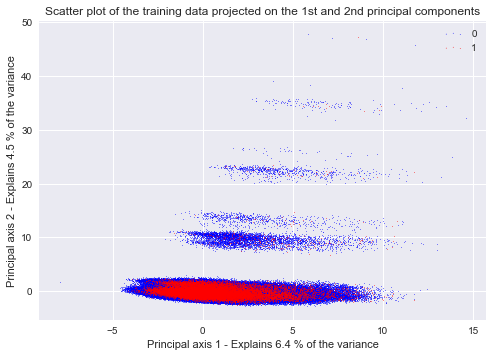

array([[  1.36806979e+00,  -4.80973108e-04,  -4.08748379e-01, ...,
         -1.03966602e+00,  -1.25414429e+00,   1.18346201e+00],
       [ -8.70643162e-01,   1.00071735e+00,   8.75455253e-01, ...,
          8.25891320e-01,  -1.02242802e+00,  -1.01560895e+00],
       [ -1.77555361e+00,  -7.66248469e-01,  -1.23583302e+00, ...,
          1.30651492e+00,  -6.31593687e-01,   8.22188045e-01],
       ..., 
       [ -2.15194013e+00,  -6.05004960e-01,   8.07746947e-01, ...,
          6.29625812e-01,   4.95201010e-02,  -6.22685832e-01],
       [  6.48186335e-02,  -1.37478955e+00,   1.30962795e+00, ...,
         -6.66358806e-01,   9.17480112e-01,  -1.21834596e+00],
       [ -6.47133426e-01,   1.93450103e-01,  -2.85890661e+00, ...,
          6.38114652e-01,  -2.45178400e+00,  -1.81420844e+00]])

In [79]:
fit_plotpca(normalized_data.drop(['target'], axis = 1),data['target'].values.astype(np.int8),n_comp = 30)

variance explained in 20 components is 0.792114901078
[ 0.10131312  0.06996592  0.06157877  0.05349298  0.04931546  0.04630098
  0.04416262  0.03718407  0.03388387  0.0330844   0.02949296  0.02916232
  0.02795805  0.0267584   0.02582322  0.0256494   0.02512169  0.02453183
  0.02371044  0.02362443]
variance for first 2 compoenents = 0.171279034467


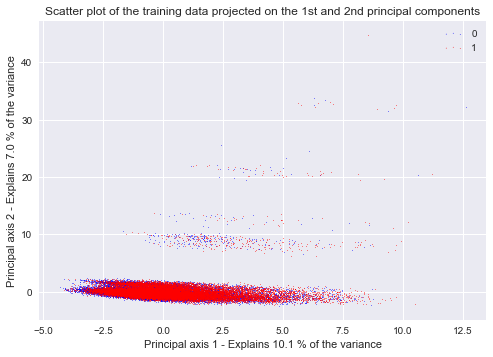

array([[ 0.01540673, -1.24326923,  2.21069784, ...,  0.21774671,
         0.21865195, -0.78085892],
       [ 1.2021082 ,  0.74761061,  1.83232048, ..., -0.68092642,
         0.22901322, -0.4382535 ],
       [-0.93190846, -0.0158419 , -0.97546603, ..., -0.24944837,
        -0.02020012, -0.2001433 ],
       ..., 
       [ 1.48664204,  0.0565749 ,  0.37694904, ...,  0.57292042,
        -0.2580067 , -1.12774949],
       [-0.46933676,  1.73972661, -0.76303889, ..., -0.00740167,
         0.08142085, -2.09597944],
       [-0.30861934, -0.71466611,  0.37388232, ..., -0.05274269,
        -0.00973036, -0.0741336 ]])

In [30]:
fit_plotpca(norm_X_data_1, data_1['target'].values.astype(np.int8), n_comp = 20)

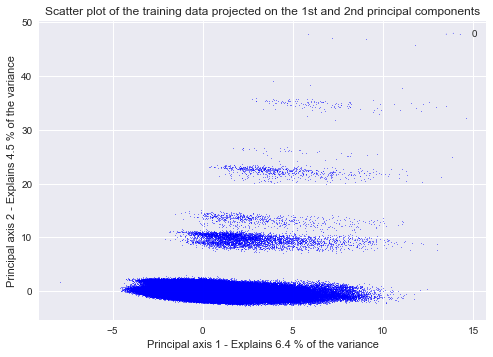

In [56]:
y = data_1['target'].values.astype(np.int8)
colors = ['b', 'r']
target_names = np.unique(y)
#for color, i, target_name in zip(colors, [0, 1], target_names):
for color, i, target_name in zip([colors[0]], [0], [target_names[0]]):
    plt.scatter(X[y == i, 0], X[y == i, 1], color=color, s=1,
                alpha=.8, label=target_name, marker='.')
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title(
        "Scatter plot of the training data projected on the 1st "
        "and 2nd principal components")
plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[1] * 100.0))

#plt.savefig('pca-porto-03.png', dpi=150)
plt.show()

We tried to visualize the data by doing a PCA. Selecting 20 features on the original dataset after normalization explains ~50% of the variability. For the reduced and normalized dataset - data_1, we can explain 79% of the variability. In the visualization in 2D, we will only be able to see 16.7 % of the variability. 

Plotting the data in 2D shows that the points labeled 1 clearly lie in the red cluster. Bad news is, this cluster lies entirely on top of the blue cluster - there is no separation, at least in these coordinates! Perhaps this is why we were not able to reach accuracies higher than ~50%. 


We tried to visualize with t-SNE which can discover more complex features, but the code was aborted because too slow. 

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50.0, learning_rate=200.0, n_iter=1000, n_iter_without_progress=300, random_state=0)
tsne.fit_transform(X)

# Imbalanced Learn

With the current dataset, linearSVM and kneighbors are both too slow - could not get them to run at all on my machine. Let us simplify the dataset.
1. Features - remove all features that have calc in the name - as we had seen earlier using our heatmaps, these features have 0 correlation with the target.
2. balancing the data. We will choose all of the row that have target = 1 and choose that number of rows with target = 0. So we will go from an imbalance of 1:32 to 1:1. Our data will also be a lot smaller, so should be much easier to train.

In [71]:
rus = RandomUnderSampler(ratio='majority', return_indices=False, random_state=None, replacement=False)
X_resampled, y_resampled = rus.fit_sample(data_1.drop(['target'], axis = 1), data['target'])
print(sorted(Counter(y_resampled).items()))

[(0, 21694), (1, 21694)]


In [72]:
scaler = StandardScaler()
X_np = scaler.fit_transform(X_resampled)
norm_X_resampled = pd.DataFrame(data=X_np, columns=data_1.drop(["target"], axis=1).columns)
norm_Y_resampled = pd.DataFrame(data=y_resampled, columns = ['target'])
norm_data_resampled = pd.concat([norm_X_resampled, norm_Y_resampled], axis=1)
norm_data_resampled.describe()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,target
count,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,...,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,43388.000000
mean,-2.892533e-15,-1.774893e-15,-2.055540e-15,-5.000047e-16,2.687528e-14,-3.283857e-14,-8.902091e-15,-9.852950e-15,3.147516e-15,2.073122e-15,...,1.826322e-14,-2.243066e-15,2.058793e-15,1.553652e-15,2.007884e-16,1.040693e-12,1.030879e-14,-1.858060e-14,7.213019e-13,0.500000
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,...,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,0.500006
min,-9.843019e-01,-3.492418e+00,-1.631444e+00,-2.879172e+00,-9.980037e-01,-7.393910e-01,-6.497571e-01,-4.572208e-01,-4.633980e-01,-1.920681e-02,...,-2.078561e+00,-2.418993e+00,-1.087205e+01,-1.851597e+00,-2.780627e+00,-4.008889e+00,-2.253245e+00,-3.485134e+00,-4.536989e+00,0.000000
25%,-9.843019e-01,-5.458729e-01,-9.032397e-01,-8.653481e-01,-3.333828e-01,-7.393910e-01,-6.497571e-01,-4.572208e-01,-4.633980e-01,-1.920681e-02,...,4.811020e-01,-1.387735e+00,8.637832e-02,-9.206313e-01,-4.057789e-01,-1.136318e+00,-6.429676e-01,1.581277e-01,-4.225611e-01,0.000000
50%,-4.876755e-01,-5.458729e-01,-1.750355e-01,-8.653481e-01,-3.333828e-01,-7.393910e-01,-6.497571e-01,-4.572208e-01,-4.633980e-01,-1.920681e-02,...,4.811020e-01,6.747815e-01,8.637832e-02,7.039685e-02,7.816451e-01,3.157570e-02,-2.245903e-01,2.630823e-01,2.876054e-01,0.500000
75%,5.055773e-01,9.273998e-01,9.172707e-01,1.148475e+00,-3.333828e-01,1.352464e+00,1.539037e+00,-4.572208e-01,-4.633980e-01,-1.920681e-02,...,4.811020e-01,6.747815e-01,8.637832e-02,9.713315e-01,7.816451e-01,6.390288e-01,4.027257e-01,3.417016e-01,7.078981e-01,1.000000
max,2.492083e+00,3.873945e+00,2.373679e+00,1.148475e+00,3.654343e+00,1.352464e+00,1.539037e+00,2.187127e+00,2.157972e+00,5.206486e+01,...,4.811020e-01,2.737298e+00,1.104481e+01,1.241612e+00,7.816451e-01,1.445327e+01,1.173945e+01,9.829496e-01,9.058876e-01,1.000000


In [16]:
train,cv=train_test_split(norm_data_resampled,test_size = 0.3, random_state=0,stratify=norm_data_resampled['target'])
X_train = train.drop("target", axis=1)
y_train = train["target"]
X_cv = cv.drop("target", axis = 1)
y_cv = cv["target"]

In [12]:
cols = ['estimator_name', 'filename', 'accuracy', 'gini_cv', 'gini_train', 'precision', 'recall', 'fscore']
results_file = open('resultsfile2.csv','a+')
line = ",".join(cols)
results_file.write(line + '\n')
results_file.close()
results = pd.DataFrame([], columns = cols)

In [14]:
from sklearn.calibration import CalibratedClassifierCV
estimators = [CalibratedClassifierCV(svm.LinearSVC(class_weight = "balanced", verbose = 2)), DecisionTreeClassifier(max_depth = 7, class_weight = "balanced"),DecisionTreeClassifier(max_depth = 9, class_weight = "balanced"),KNeighborsClassifier(n_neighbors=5)]
filenames = ['SVC_C1_linear_1', 'DecTree_7_1','DecTree_9_1','KNeigh_5_1']
estimators = [GaussianNB()]
filenames = ['GaussianNB_1']
estimators = [LogisticRegression(C = 1, class_weight = "balanced"), CalibratedClassifierCV(svm.LinearSVC(class_weight = "balanced", verbose = 2)), DecisionTreeClassifier(max_depth = 3, class_weight = "balanced"),DecisionTreeClassifier(max_depth = 5, class_weight = "balanced"), RandomForestClassifier(max_depth=2, random_state=0, class_weight = "balanced", verbose = 2), KNeighborsClassifier(n_neighbors=3)]
filenames = ['logistic_C1_1', 'SVC_C1_linear_1', 'DecTree_3_1','DecTree_5_1','RandForest_1', 'KNeigh_3_1']
#for i in range(0,len(estimators)):
#for i in [0,2,3,4,5]:
for i in range(0,1):
    estimator = estimators[i]
    filename = filenames[i]
    results_list =  evaluate_clf(estimator, X_train, y_train, X_cv, y_cv, filename)
    print(results_list)
    df = pd.DataFrame([results_list], columns = cols)
    results = pd.concat([results, df],ignore_index=True)
    line = str(results_list)[1:-1]
    results_file = open('resultsfile2.csv','a')
    results_file.write(line + '\n')
    results_file.close()
    
print(results)

['LogisticRegression', 'logistic_C1_1.pkl', 0.58262272412998384, 0.23103153564593024, 0.26061502065421577, 0.58906379453189728, 0.54625076828518748, 0.56685003587658467]
       estimator_name           filename  accuracy   gini_cv  gini_train  \
0          GaussianNB   GaussianNB_1.pkl  0.570177  0.230329    0.245074   
1  LogisticRegression  logistic_C1_1.pkl  0.582623  0.231032    0.260615   

   precision    recall    fscore  
0   0.628050  0.344038  0.444555  
1   0.589064  0.546251  0.566850  


Let's try visualizations again on this reduced dataset. 

variance explained in 33 components is 0.99353695702
[ 0.10126518  0.06969695  0.06155019  0.05326968  0.04975134  0.04694001
  0.04400762  0.03725121  0.03390446  0.0332079   0.02928525  0.02908763
  0.02774824  0.02665078  0.02626857  0.02583393  0.02505561  0.02451188
  0.02357397  0.02347593  0.02269034  0.02079447  0.01978318  0.01894905
  0.018348    0.01669717  0.0157387   0.01530413  0.01464707  0.01313152
  0.00999824  0.00885673  0.00626205]
variance for first 2 compoenents = 0.170962130492


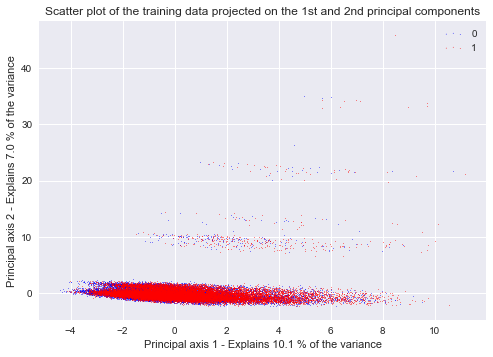

In [80]:
X = fit_plotpca(norm_data_resampled.drop("target", axis = 1),norm_data_resampled['target'].values.astype(np.int8), 33)

This still looks like a decent representation of the original dataset, but it is much smaller in size. We have gone from 600,000 to 40,000. Let's try to reduce this further to size of 5000 by undersampling both classes so that we can quickly try a variety of nonlinear models or non linear features. 

variance explained in 33 components is 0.993772449696
[ 0.10256852  0.06802788  0.06313587  0.05403543  0.05106506  0.04742756
  0.0429225   0.03688483  0.03432842  0.03260836  0.03046395  0.02958041
  0.02825547  0.02813696  0.02653237  0.02592642  0.02529583  0.02446526
  0.02321221  0.02236147  0.02208307  0.02059733  0.01886145  0.01850751
  0.01688358  0.01653646  0.01583637  0.01511229  0.01461986  0.01329493
  0.00969615  0.00856751  0.00594118]
variance for first 2 compoenents = 0.170596393924


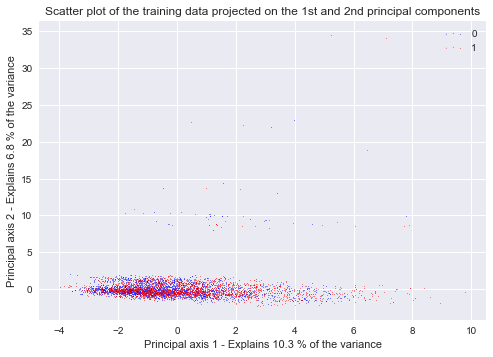

In [178]:
choose = np.random.randint(0, norm_data_resampled.shape[0]-1, size=5000)
norm_data_resampled_2 = norm_data_resampled.iloc[choose]
n_comp = 33
X = fit_plotpca(norm_data_resampled_2.drop("target", axis = 1),norm_data_resampled_2['target'].values.astype(np.int8), n_comp)
y = norm_data_resampled_2['target'].values.astype(np.int8)

We are at 5000 datapoints and the data still looks somewhat similar in PCA! Now we can try some fancy nonlinear stuff. 

# Non-linear features/algorithms

From the first 33 principal components, of the dataset of size 5000, I will generate 33C2 additional features = 528 additional features. Then I will try PCA again.

In [169]:
import itertools
iterator = list(itertools.combinations(range(0,n_comp), 2))

In [170]:
X_expand = X
total = X.shape[1] + len(iterator)
for cols in iterator:
    #cols = iterator[1]
    feature = np.reshape(X[:,cols[0]]*X[:,cols[1]], (-1,1))
    X_expand = np.append(X_expand, feature, axis = 1)
X_expand.shape
#renormalize data
scaler = StandardScaler()
X_expand = scaler.fit_transform(X_expand)

In [171]:
X_expand = pd.DataFrame(data = X_expand, columns = range(0, total))
X_expand.describe()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,...,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,-5.656586e-18,-5.466183e-17,-4.218847e-19,2.077227e-17,-2.051692e-17,4.891643e-17,-9.059420e-18,-4.383161e-17,2.065015e-17,-1.145750e-17,...,4.638512e-17,-5.551115e-20,2.755574e-17,3.069767e-18,5.634382e-17,-2.968736e-17,5.973000e-18,-2.206013e-17,-1.636191e-18,-1.136591e-17
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,...,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-2.209266e+00,-1.639441e+00,-3.126437e+00,-2.780568e+00,-3.655064e+00,-3.179503e+00,-3.785591e+00,-3.405736e+00,-5.607333e+00,-8.750847e+00,...,-2.704069e+00,-1.856302e+00,-7.221658e+00,-6.551295e+00,-1.618169e+01,-7.431785e+00,-7.227945e+00,-1.062292e+01,-1.038471e+01,-1.644967e+01
25%,-7.014492e-01,-3.652677e-01,-6.839563e-01,-6.819360e-01,-6.211180e-01,-7.214226e-01,-6.356899e-01,-6.957244e-01,-6.573269e-01,-5.147830e-01,...,-1.533754e-01,-7.466951e-02,-3.233878e-01,-1.922597e-01,-2.938212e-01,-4.342416e-01,-3.158541e-01,-3.560021e-01,-2.761397e-01,-3.332306e-01
50%,-1.773597e-01,-6.643494e-02,-1.000619e-01,-5.624157e-02,1.074995e-01,4.287717e-02,1.432438e-01,7.232353e-03,-9.854958e-02,2.582641e-02,...,-2.017770e-03,-1.447931e-03,-1.659525e-03,-1.180715e-04,-4.649339e-03,-5.360205e-03,-3.048006e-03,7.906548e-05,4.106078e-03,-2.161328e-02
75%,4.657191e-01,2.126647e-01,6.239947e-01,6.350756e-01,7.050162e-01,7.112805e-01,7.274367e-01,6.919869e-01,5.548096e-01,5.426543e-01,...,1.316626e-01,6.067036e-02,3.062759e-01,1.703288e-01,2.793761e-01,3.935764e-01,3.388987e-01,3.486243e-01,2.721235e-01,2.719710e-01
max,6.890703e+00,2.231412e+01,5.097654e+00,5.864701e+00,4.598943e+00,3.887980e+00,4.724487e+00,3.416153e+00,9.532484e+00,1.402220e+01,...,8.348728e+01,9.706729e+01,5.760129e+01,7.682512e+01,1.241903e+01,8.759798e+00,9.334457e+00,9.648121e+00,1.257792e+01,1.091182e+01


variance explained in 100 components is 0.547690335759
[ 0.0722785   0.05486642  0.03402834  0.01991806  0.01614672  0.01394038
  0.01263593  0.01074817  0.00938041  0.00823687  0.00789499  0.00740747
  0.00712648  0.00679597  0.00667965  0.00637366  0.005679    0.0053904
  0.00518648  0.00497784  0.00482401  0.00469754  0.00455428  0.00450136
  0.00444561  0.00422122  0.00415279  0.00405624  0.00396901  0.00389588
  0.00383716  0.00377177  0.00362981  0.003575    0.00354765  0.00348853
  0.00340733  0.00336734  0.00329104  0.00326343  0.00323229  0.00318494
  0.00317338  0.00312595  0.00305733  0.00302254  0.00298276  0.00296229
  0.00293084  0.00291493  0.00285375  0.00283283  0.002792    0.00277427
  0.00276171  0.00271784  0.00269374  0.00268209  0.00267489  0.00265517
  0.00264424  0.00263145  0.00260189  0.00258671  0.00256007  0.00254364
  0.00253532  0.00252296  0.00250054  0.00249744  0.00248549  0.00247576
  0.00245828  0.0024476   0.00242854  0.00242252  0.00241463  0.002408

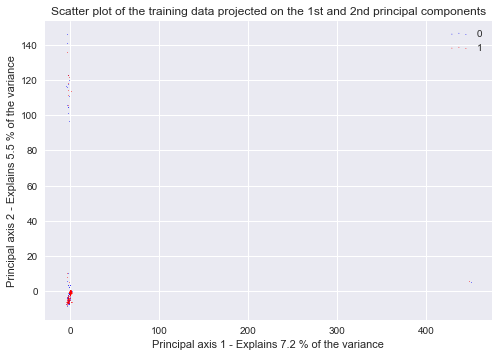

In [172]:
X = fit_plotpca(X_expand,norm_data_resampled_2['target'].values.astype(np.int8), 100)

In [154]:
X[y == 0, 0].shape

(2527L,)

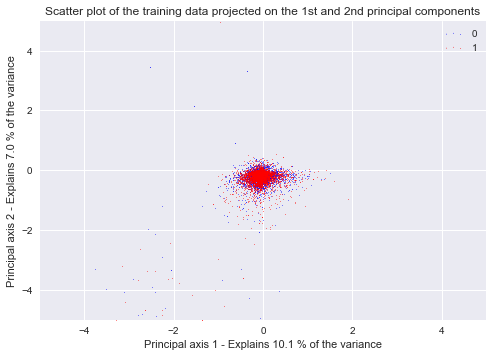

In [177]:
    
    y = norm_data_resampled_2['target'].values.astype(np.int8)
    colors = ['b', 'r']
    target_names = np.unique(y)
    for color, i, target_name in zip(colors, [0, 1], target_names):
    #for color, i, target_name in zip([colors[0]], [0], [target_names[0]]):
        plt.scatter(X[y == i, 0], X[y == i, 1], color=color, s=1, alpha=0.8, label=target_name, marker='.')
    plt.legend(loc='best', shadow=False, scatterpoints=3)
    plt.title( "Scatter plot of the training data projected on the 1st "
        "and 2nd principal components")
    plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[0] * 100.0))
    plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[1] * 100.0))
    plt.axis([-5,5,-5,5])
    #plt.savefig('pca-porto-03.png', dpi=150)
    plt.show()

This doesn't look like it helped at all in separating the two classes. We will stick to 33 features from the original PCA to try out other classification algos. 

In [180]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(kernel="poly", n_jobs = -1)
X_kpca = kpca.fit_transform(norm_data_resampled_2.drop("target", axis = 1))

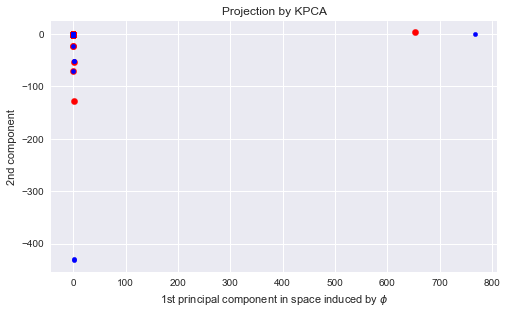

In [190]:
X_polypca = X_kpca
reds = y == 0
blues = y == 1
plt.figure()
plt.subplot(1, 1, 1, aspect='equal')
plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c="red", s=40)
plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c="blue", s=20)
plt.title("Projection by KPCA")
plt.xlabel("1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")
#plt.subplots_adjust(0.02, 0.10, 0.98, 0.94, 0.04, 0.35)

plt.show()

The first attempt at kPCA did not yield much.

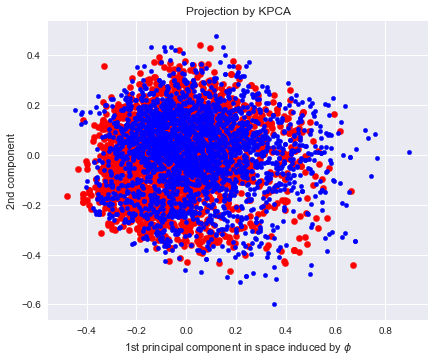

In [191]:
kpca = KernelPCA(kernel="sigmoid", n_jobs = -1)
X_kpca = kpca.fit_transform(norm_data_resampled_2.drop("target", axis = 1))
X_sigmoidpca = X_kpca
reds = y == 0
blues = y == 1
plt.figure()
plt.subplot(1, 1, 1, aspect='equal')
plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c="red", s=40)
plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c="blue", s=20)
plt.title("Projection by KPCA")
plt.xlabel("1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")
#plt.subplots_adjust(0.02, 0.10, 0.98, 0.94, 0.04, 0.35)

plt.show()

Sigmoid kernel gives 2 clouds, one pretty much on top of the other. We are looking for separation, so this doesn't help. 

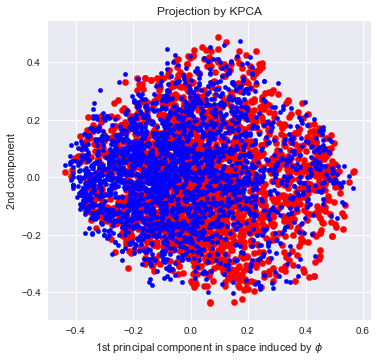

In [193]:
kpca = KernelPCA(kernel="rbf", n_jobs = -1)
X_kpca = kpca.fit_transform(norm_data_resampled_2.drop("target", axis = 1))
X_gausspca = X_kpca
reds = y == 0
blues = y == 1


The gaussian kernel seems like it helped somewhat, compared to what we saw for the sigmoid kernel. Perhaps some more tuning might help get better separation? First, let's replot this same one with smaller point sizes so we can more clearly see if there is really a separation. 

In general, I see more reds towards the left of the figure than to the right. 

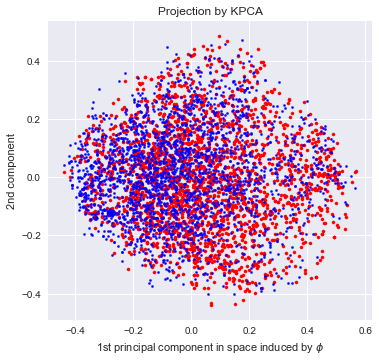

In [196]:
plt.figure()
plt.subplot(1, 1, 1, aspect='equal')
plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c="red", s=10)
plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c="blue", s=5)
plt.title("Projection by KPCA")
plt.xlabel("1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")
#plt.subplots_adjust(0.02, 0.10, 0.98, 0.94, 0.04, 0.35)

plt.show()

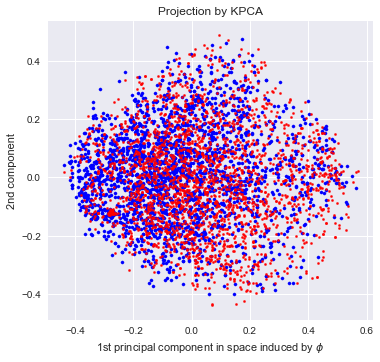

In [197]:
plt.figure()
plt.subplot(1, 1, 1, aspect='equal')
plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c="blue", s=10)
plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c="red", s=5)
plt.title("Projection by KPCA")
plt.xlabel("1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")
#plt.subplots_adjust(0.02, 0.10, 0.98, 0.94, 0.04, 0.35)

plt.show()

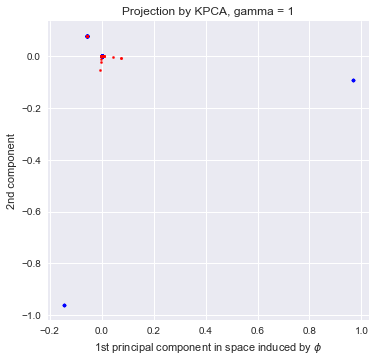

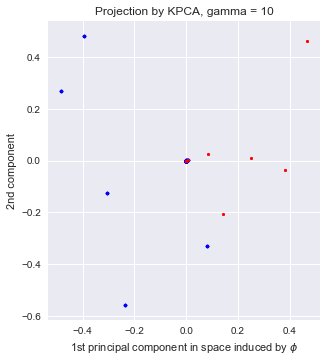

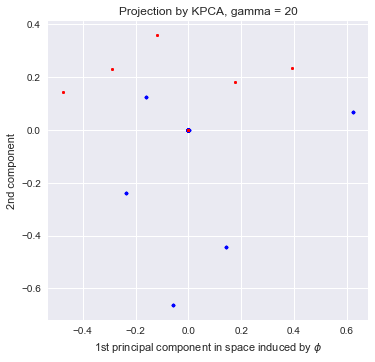

In [199]:
gammas = [1, 10, 20] 
for g in gammas:
    kpca = KernelPCA(kernel="rbf", n_jobs = -1, gamma = g )
    X_kpca = kpca.fit_transform(norm_data_resampled_2.drop("target", axis = 1))
    reds = y == 0
    blues = y == 1
    plt.figure()
    plt.subplot(1, 1, 1, aspect='equal')
    plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c="blue", s=10)
    plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c="red", s=5)
    plt.title("Projection by KPCA, gamma = " + str(g))
    plt.xlabel("1st principal component in space induced by $\phi$")
    plt.ylabel("2nd component")
#plt.subplots_adjust(0.02, 0.10, 0.98, 0.94, 0.04, 0.35)
    plt.show()


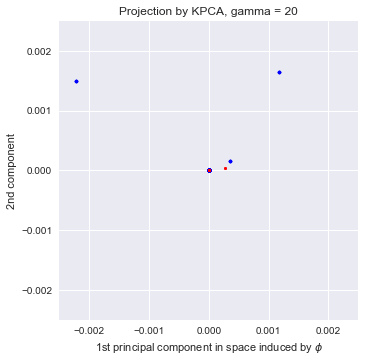

In [207]:
X_pca_20 = X_kpca
plt.figure()
plt.subplot(1, 1, 1, aspect='equal')
plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c="blue", s=10)
plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c="red", s=5)
plt.title("Projection by KPCA, gamma = " + str(g))
plt.xlabel("1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")
plt.axis([-.0025, 0.0025, -0.0025, 0.0025])
#plt.subplots_adjust(0.02, 0.10, 0.98, 0.94, 0.04, 0.35)
plt.show()

In [210]:
len(kpca.lambdas_)

4862

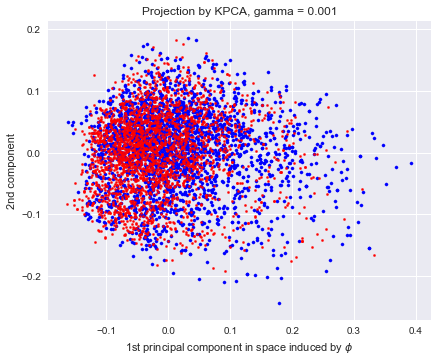

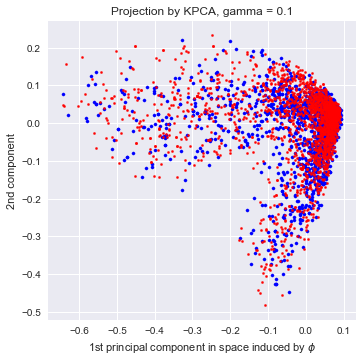

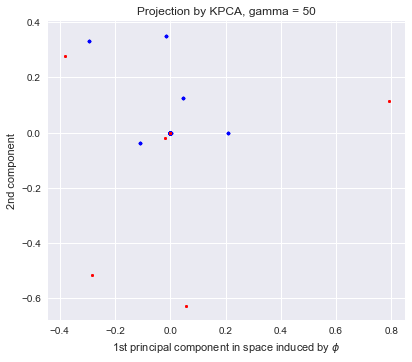

In [213]:
gammas = [.001, .1, 50]
kpca = [0,0,0]
for g,i in zip(gammas, range(0,3)):
    kpca[i] = KernelPCA(kernel="rbf", n_jobs = -1, gamma = g )
    X_kpca = kpca[i].fit_transform(norm_data_resampled_2.drop("target", axis = 1))
    reds = y == 0
    blues = y == 1
    plt.figure()
    plt.subplot(1, 1, 1, aspect='equal')
    plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c="blue", s=10)
    plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c="red", s=5)
    plt.title("Projection by KPCA, gamma = " + str(g))
    plt.xlabel("1st principal component in space induced by $\phi$")
    plt.ylabel("2nd component")
#plt.subplots_adjust(0.02, 0.10, 0.98, 0.94, 0.04, 0.35)
    plt.show()

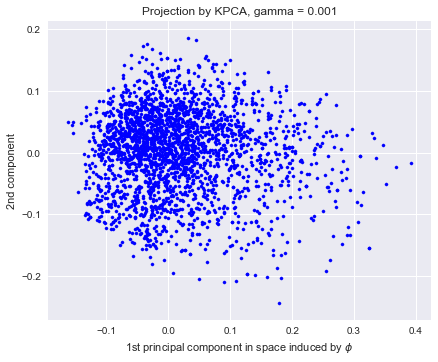

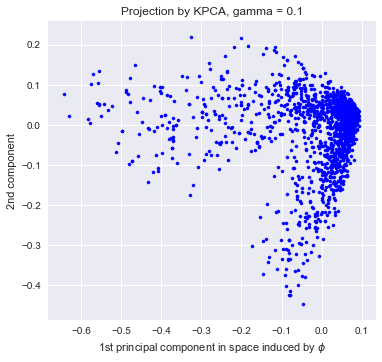

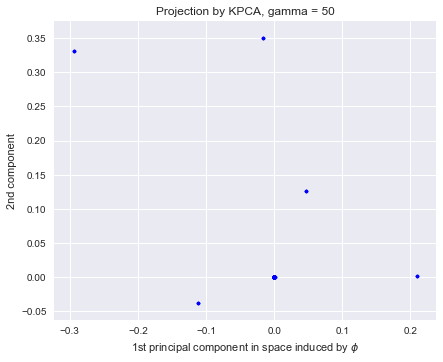

In [214]:
for g,i in zip(gammas, range(0,3)):
    #kpca[i] = KernelPCA(kernel="rbf", n_jobs = -1, gamma = g )
    X_kpca = kpca[i].transform(norm_data_resampled_2.drop("target", axis = 1))
    reds = y == 0
    blues = y == 1
    plt.figure()
    plt.subplot(1, 1, 1, aspect='equal')
    plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c="blue", s=10)
    #plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c="red", s=5)
    plt.title("Projection by KPCA, gamma = " + str(g))
    plt.xlabel("1st principal component in space induced by $\phi$")
    plt.ylabel("2nd component")
#plt.subplots_adjust(0.02, 0.10, 0.98, 0.94, 0.04, 0.35)
    plt.show()

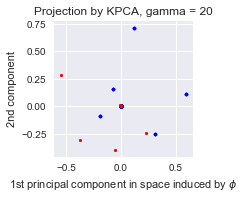

In [216]:
gammas = [20]
kpca = [0,0,0]
for g,i in zip(gammas, range(0, len(gammas))):
    kpca[i] = KernelPCA(kernel="rbf", n_jobs = -1, gamma = g, n_components = 100 )
    X_kpca = kpca[i].fit_transform(norm_data_resampled_2.drop("target", axis = 1))
    #X_back = kpca.inverse_transform(X_kpca)
    reds = y == 0
    blues = y == 1
    plt.figure()
    plt.subplot(2, 2, 1, aspect='equal')
    plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c="blue", s=10)
    plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c="red", s=5)
    plt.title("Projection by KPCA, gamma = " + str(g))
    plt.xlabel("1st principal component in space induced by $\phi$")
    plt.ylabel("2nd component")
#plt.subplots_adjust(0.02, 0.10, 0.98, 0.94, 0.04, 0.35)
    plt.show()

# Making predictions on test data

In [17]:
test = pd.read_csv('test.csv')
cols_trimmed = [x for x in test.columns if 'calc' not in x]
test_1 = test[cols_trimmed]
scaler = StandardScaler()
X_np = scaler.fit_transform(test_1)
norm_test = pd.DataFrame(data=X_np, columns=cols_trimmed)
clf = joblib.load('logistic_C1_1.pkl')
y = clf.predict_proba(norm_test)

In [21]:
df = pd.DataFrame.from_items([("target", y[:,1])])
test_results = pd.concat([test["id"], df], axis = 1)
test_results.to_csv("submission.csv", index = False)